In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import gaitFunctions
import combineClips
import plotClip
import os
import glob
import seaborn as sns
from scipy import stats
import cv2

def meanstdstr(vals):
    return str(np.round(np.mean(vals),2)) + ' ± ' + str(np.round(np.std(vals),2))

In [2]:
# plot colors and parameters
axis_fontsize=11
tick_fontsize=9

# colors for step kinematics
stance_color = '#5656ff'
swing_color = '#e1e813'
duty_color = '#4d4d4d'
ipsi_color = 'tab:red'
contra_color = 'tab:green'

# colors for legs
first_pair_color = '#bc272d' # red
first_pair_color_alt = '#f77276' # salmon
second_pair_color = '#50a9d4' # teal
second_pair_color_alt = '#95dafc' # sky blue
third_pair_color = '#fa9805' # orange
third_pair_color_alt = '#e9c716' # gold
rear_leg_color = '#0000a2' # indigo
rear_leg_color_alt = '#703391'# violet

# scatter marker size and alpha
marker_size = 10
marker_alpha = 0.7
marker_color = 'k'

# Get timing of original videos (can skip down to load data)

In [ ]:
# navigate to directory that contains the data
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/videos_exemplaris/')
# list directories within this directory
dirs = []
for dirname, dirnames, filenames in os.walk('.'):
    # print path to all subdirectories first.
    for subdirname in dirnames:
        folder = os.path.join(dirname, subdirname).split('/')[1]
        if folder not in dirs:
            dirs.append(folder)
dirs = np.sort(np.unique(np.array(dirs)))
dirs = [x for x in dirs if 'exemplaris' in x]
folders_in_analysis = gaitFunctions.selectMultipleFromList(dirs) # 1,4,6,9 for exemplaris

In [ ]:
# get durations of videos (in seconds)
# if there is a 'vid_info.csv' file already, then great!
# if not, we need to make this file ... and the videos need to be downloaded on the hard drive
# (if they are in the cloud, this will freeze)

vids = []
video_folder = 'original_videos'
vid_info_file = 'vid_info.csv'
vid_df = pd.DataFrame()

for folder in folders_in_analysis:
    vids_in_folder = []
    have_vid_info = False
    
    # collect names of videos in this folder
    for extension in ['*mp4','*mov']:
        vids_in_folder.extend(glob.glob(os.path.join(folder,video_folder,extension)))
    
    # add names of videos in this folder to overall list
    vids_in_folder = sorted(vids_in_folder)
    vids.extend(vids_in_folder)
    
    # do we already have vid info for this folder?
    vid_info_path = os.path.join(folder,video_folder,vid_info_file)
    if len(glob.glob(vid_info_path)) > 0:  
        
        these_vids_df = pd.read_csv(vid_info_path)
        have_vid_info = True
        print('Found vid info in ' + folder)
        if len(vid_df) > 0:
            vid_df = pd.concat([vid_df, these_vids_df])
        else:
            vid_df = these_vids_df
            
    if have_vid_info == False:
        print('We need vid info for ' + folder)
        vid_names = []
        fps = []
        width = []
        height = []
        frames = []
        duration = []
        for vid in vids_in_folder:
            parent_dir, original_video_dir, vid_name = vid.split('/')
            vid_names.append(vid_name)
#             print(vid_name) # testing OK
            cap = cv2.VideoCapture(vid)
            frames_per_sec = cap.get(cv2.CAP_PROP_FPS)
            fps.append(frames_per_sec)
            width.append(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            height.append(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            totalNoFrames = cap.get(cv2.CAP_PROP_FRAME_COUNT)
            frames.append(totalNoFrames)
            duration.append(totalNoFrames / frames_per_sec)
            cap.release()

        vid_info_dict = {
            'Video File':vid_names,
            'fps':fps,
            'width':width,
            'height':height,
            'frames':frames,
            'duration':duration
        }
        these_vids_df = pd.DataFrame(vid_info_dict)
        
        if len(vid_df) > 0:
            vid_df = pd.concat([vid_df, these_vids_df])
        else:
            vid_df = these_vids_df

        # save dataFrame to csv
        these_vids_df.to_csv(os.path.join(folder,video_folder,vid_info_file), index=False)

num_videos = len(vids)
vid_files = sorted(vids)
print()
print('Total number of videos: ' + str(num_videos)) 
print('Mean video length: ' + meanstdstr(vid_df.duration.values) + ' seconds')
vid_df.head(3)

# Combine data from folders ... (OR see below)

In [ ]:
# combine data from these folders into dataframes ... takes awhile
this_treatment = 'exemplaris'
current_dir = os.getcwd()

path_summaries_df = pd.DataFrame()
step_timing_combined_df = pd.DataFrame()
step_summaries_df = pd.DataFrame()
gait_summaries_df = pd.DataFrame()
gait_styles_speeds_df = pd.DataFrame()

def combineDF(original,new):
    if len(original) == 0:
        original = new
    else:
        new = pd.concat([original, new])
    return new

for folder in folders_in_analysis:
    os.chdir(folder)
    print('Getting data from ' + folder)
    pdf, stcdf, sdf, gdf, gssdf = combineClips.main(False)
    os.chdir(current_dir)
    path_summaries_df = combineDF(path_summaries_df, pdf)
    step_timing_combined_df = combineDF(step_timing_combined_df, stcdf)
    step_summaries_df = combineDF(step_summaries_df, sdf)
    gait_summaries_df = combineDF(gait_summaries_df, gdf)
    gait_styles_speeds_df = combineDF(gait_styles_speeds_df, gssdf)
    
path_summaries_df['treatment'] = [this_treatment] * len(path_summaries_df)
step_summaries_df['treatment'] = [this_treatment] * len(step_summaries_df)
gait_summaries_df['treatment'] = [this_treatment] * len(gait_summaries_df)

In [ ]:
print('Mean duration analyzed: ' + meanstdstr(path_summaries_df['Duration analyzed (sec)'].values) + ' seconds')
print('Mean tardigrade length: ' + meanstdstr(path_summaries_df['Body Length (mm)'].values*1000) + ' µm')
distances = path_summaries_df['Distance traveled (mm)'].values
lengths = path_summaries_df['Body Length (mm)'].values
bodylengths_traveled = distances / lengths
print('Mean bodylength traveled: ' + meanstdstr(bodylengths_traveled))

In [ ]:
# add the original video lengths to the dataframe
# add the bodylength traveled to the dataframe
df_cols = list(path_summaries_df.columns.values)
path_summaries_df['Original Video Length (sec)'] = vid_df.duration.values
path_summaries_df['Body Lengths Traveled'] = bodylengths_traveled
path_summaries_df.head(3)

In [ ]:
# save dataframe to analysis folder for use by subsequent notebooks
from datetime import date
today = str(date.today())

# navigate to directory where the combined data for treatments is stored
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/analyses_summaries/')

this_treatment = 'all_exemplaris'
out_file = this_treatment + '_' + today + '.xlsx'

print('\nCombining data from all clips into ' + out_file)
with pd.ExcelWriter(out_file, engine='openpyxl') as writer: 
    if len(path_summaries_df) > 0:
        path_summaries_df.to_excel(writer, index=False, sheet_name='path_summaries')
    if len(step_timing_combined_df) > 0:
        step_timing_combined_df.to_excel(writer, index=False, sheet_name='step_timing')
    if len(step_summaries_df) > 0:
        step_summaries_df.to_excel(writer, index=False, sheet_name='step_summaries')
    if len(gait_summaries_df) > 0:
        gait_summaries_df.to_excel(writer, index=False, sheet_name='gait_summaries')
    if len(gait_styles_speeds_df) > 0:
        gait_styles_speeds_df.to_excel(writer, index=False, sheet_name='gait_speeds')

# ... OR load data that is already good to go

In [3]:
# navigate to directory that contains the data
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/analyses_summaries')
xl_files = sorted(glob.glob('*.xlsx'))
excel_file = gaitFunctions.selectOneFromList(xl_files)

path_summaries_df = pd.read_excel(excel_file, sheet_name='path_summaries', index_col=None)
path_summaries_df.head(2)


Choose from this list : 
1: all_exemplaris_2024-04-03.xlsx
2: misc_oldclip_exemplaris_2024-03-11.xlsx
3: new50_exemplaris_2024-04-01.xlsx
4: old50_exemplaris_2024-02-14.xlsx
5: path_summaries.xlsx
6: step_summaries.xlsx

Which ONE would you like? 1

You chose all_exemplaris_2024-04-03.xlsx



,Identifier,treatment,individual,date,Scale (pixels in 1mm),Body Size (mm^2),Body Length (mm),Body Width (mm),Body Width/Length Ratio,Duration analyzed (sec),...,Speed (body lengths / sec cruising),Total bearing change (deg),Bearing change (deg) / sec,Bearing change (deg) / sec cruising,Number of stops,Stops / sec,Number of turns,Turns / sec,Original Video Length (sec),Body Lengths Traveled
0,iw_11dec_tardigrade01_exemplaris,exemplaris,tardigrade01,11dec,956.03,0.017560,0.265809,0.089788,0.337792,112.6362,...,0.179656,2146.3928,19.055977,16.867627,10,0.088781,4,0.035513,137.454545,19.343800
1,iw_11dec_tardigrade02_exemplaris,exemplaris,tardigrade02,11dec,956.03,0.013457,0.239711,0.073674,0.307344,110.1818,...,0.222783,1648.0518,14.957568,16.375356,11,0.099835,1,0.009076,137.545455,21.442264


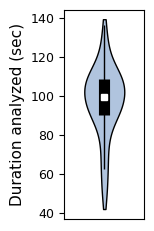

In [4]:
col = 'Duration analyzed (sec)'
f = plt.figure(figsize=(1,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = gaitFunctions.singleViolinBox(ax,path_summaries_df,col,False)
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

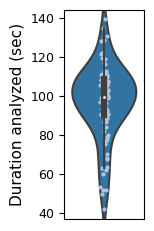

In [5]:
# try seaborn
col = 'Duration analyzed (sec)'
f = plt.figure(figsize=(1,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = gaitFunctions.singleViolinPoints(ax,path_summaries_df,col,True) # False if no box
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

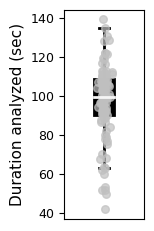

In [6]:
# boxplot with dots
f = plt.figure(figsize=(1,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = gaitFunctions.singleBoxplot(ax, path_summaries_df, 'Duration analyzed (sec)')
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

In [7]:
print(path_summaries_df.columns)

Index(['Identifier', 'treatment', 'individual', 'date',
       'Scale (pixels in 1mm)', 'Body Size (mm^2)', 'Body Length (mm)',
       'Body Width (mm)', 'Body Width/Length Ratio', 'Duration analyzed (sec)',
       'Distance traveled (mm)', 'Speed (mm/sec)',
       'Speed (body lengths / sec)', 'Percentage of time cruising',
       'Speed (mm/sec cruising)', 'Speed (body lengths / sec cruising)',
       'Total bearing change (deg)', 'Bearing change (deg) / sec',
       'Bearing change (deg) / sec cruising', 'Number of stops', 'Stops / sec',
       'Number of turns', 'Turns / sec', 'Original Video Length (sec)',
       'Body Lengths Traveled'],
      dtype='object')


In [8]:
# look for outliers in a particular column
col = 'Percentage of time cruising' # 'Body Length (mm)''
df = path_summaries_df[['Identifier',col]]
df.sort_values(by=col).head(30)

,Identifier,Percentage of time cruising
73,iw_8mar_tardigrade15_unknown,54.340278
24,iw_21dec_tardigrade05_exemplaris,58.421673
2,iw_11dec_tardigrade03_exemplaris,59.297344
54,iw_12mar_tardigrade25_exemplaris,62.773452
37,ea_19mar_tardigrade39_exemplaris,63.059452
50,iw_11mar_tardigrade21_exemplaris,66.010872
49,iw_11mar_tardigrade20_exemplaris,69.849521
95,iw_9nov_tardigrade10_exemplaris,70.215503
72,iw_8mar_tardigrade14_unknown,71.143995
82,sh_26mar_tardigrade46_unknown,72.987165


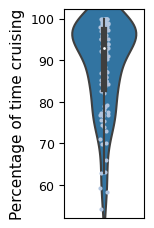

In [9]:
# show column of interest
col = 'Percentage of time cruising' # 'Body Length (mm)''
f = plt.figure(figsize=(1,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = gaitFunctions.singleViolinPoints(ax, path_summaries_df, col, True)
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

# Plot ALL the data 
## and record everything into a dataframe 
### (which can be formatted as a table)

In [10]:
# print(path_summaries_df.columns)
columns_to_analyze = [
    'Original Video Length (sec)', 
#     'Duration analyzed (sec)',
    'Body Size (mm^2)',
    'Body Length (mm)',
    'Body Width (mm)', 
    'Body Width/Length Ratio', 
    'Distance traveled (mm)', 
    'Body Lengths Traveled',
    'Percentage of time cruising',
    'Speed (mm/sec)',
    'Speed (body lengths / sec)', 
    'Speed (mm/sec cruising)', 
    'Speed (body lengths / sec cruising)',
    #'Total bearing change (deg)', 
    'Bearing change (deg) / sec',
    'Bearing change (deg) / sec cruising', 
    #'Number of stops', 
    'Stops / sec',
    #'Number of turns', 
    'Turns / sec'
]
print(len(columns_to_analyze))

16


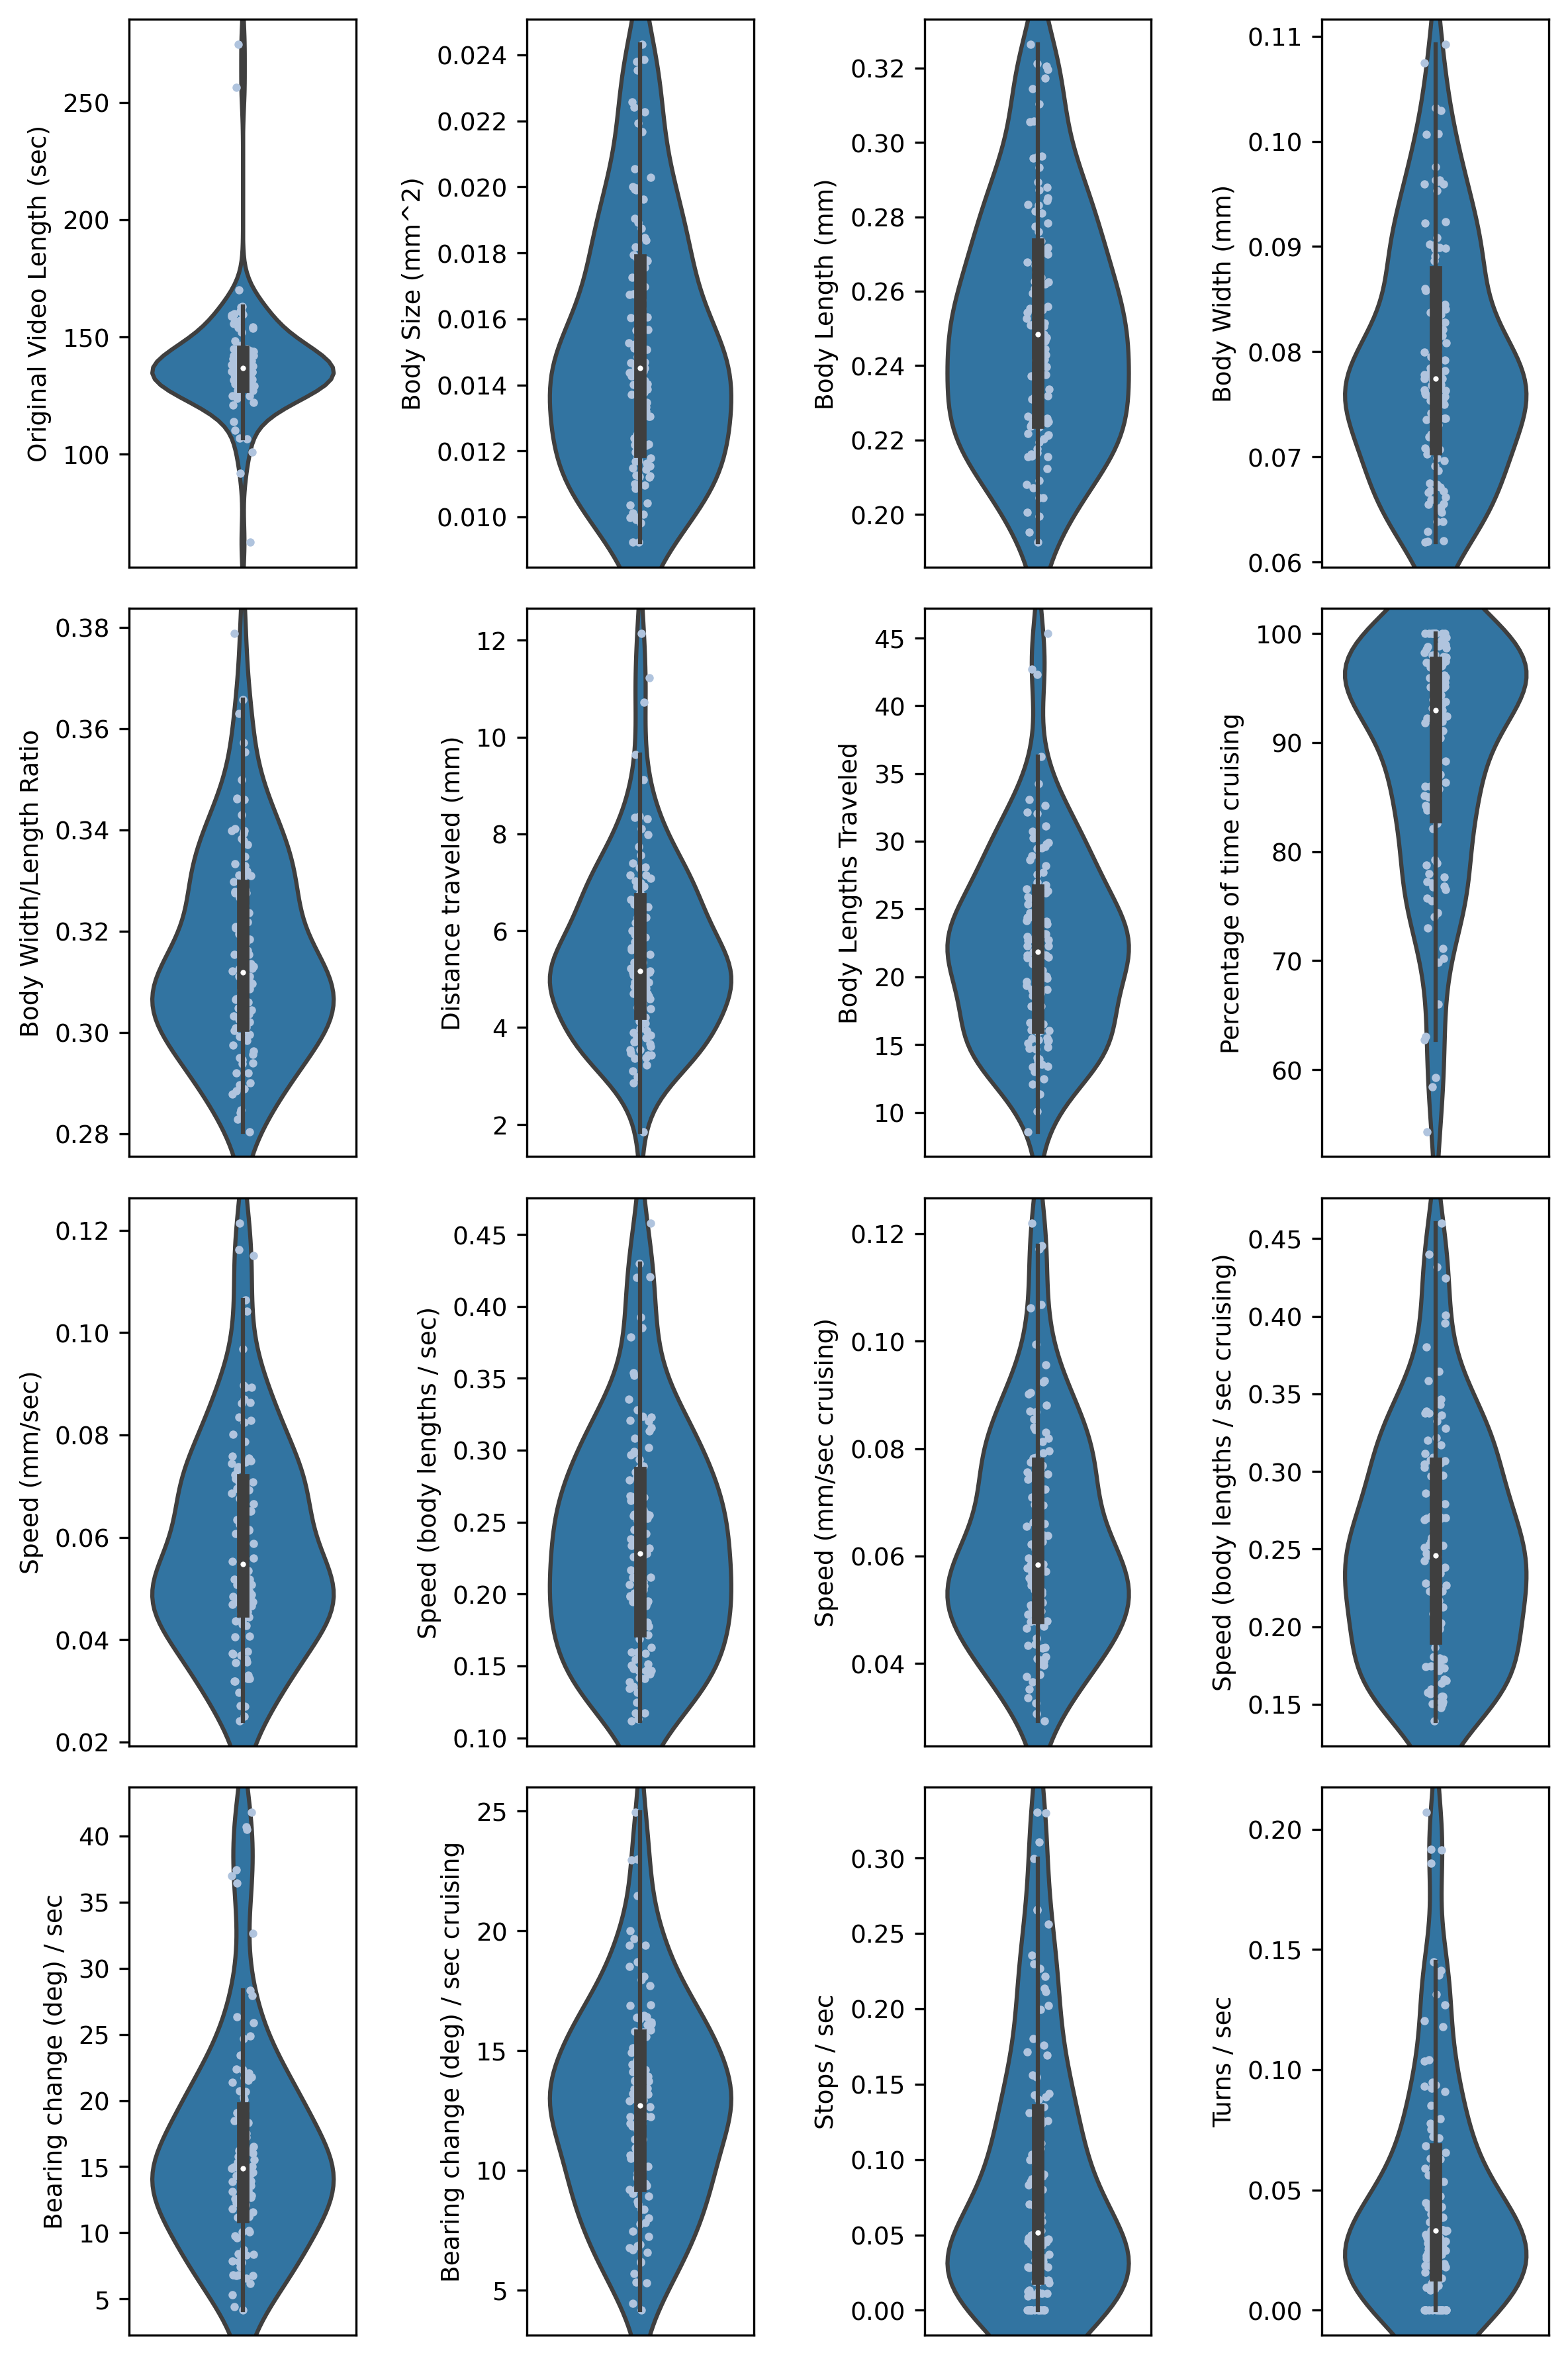

In [13]:
rows,cols = [4,4]
f,axes = plt.subplots(rows,cols,figsize = (8,12), dpi=300)
axes_list = axes.reshape(1,len(columns_to_analyze))[0]
for i, col in enumerate(columns_to_analyze):
    axes_list[i] = gaitFunctions.singleViolinPoints(axes_list[i], path_summaries_df, col, True)
    axes_list[i].yaxis.label.set_size(tick_fontsize)
    axes_list[i].tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.tight_layout()
plt.show()

In [14]:
# make a table of the data ... can screenshot this?
means = [np.round(np.mean(path_summaries_df[col].values),2) for col in columns_to_analyze]
sds = [np.round(np.std(path_summaries_df[col].values),2) for col in columns_to_analyze]
meanstd = [str(m) + ' ± ' + str(sds[i]) for i,m in enumerate(means)]
summary_df = pd.DataFrame({'Measurement':columns_to_analyze,
                          'Mean':means,
                          'SD':sds,
                          'Mean ± Std':meanstd})
blankIndex=[''] * len(summary_df)
summary_df.index=blankIndex
display(summary_df[['Measurement','Mean ± Std']])

,Measurement,Mean ± Std
,Original Video Length (sec),138.61 ± 23.45
,Body Size (mm^2),0.02 ± 0.0
,Body Length (mm),0.25 ± 0.03
,Body Width (mm),0.08 ± 0.01
,Body Width/Length Ratio,0.32 ± 0.02
,Distance traveled (mm),5.55 ± 1.81
,Body Lengths Traveled,22.25 ± 7.02
,Percentage of time cruising,88.68 ± 10.93
,Speed (mm/sec),0.06 ± 0.02
,Speed (body lengths / sec),0.23 ± 0.08


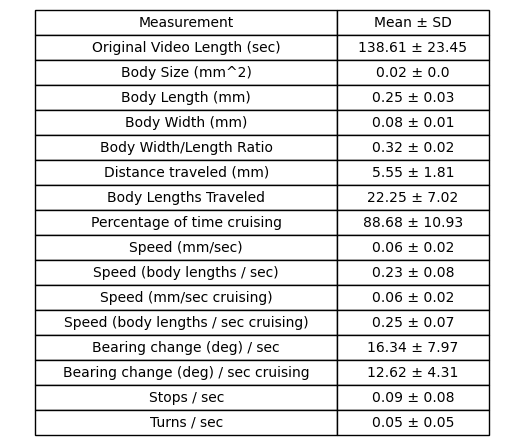

In [15]:
# table in matplotlib figure
fig,ax = plt.subplots(figsize=(6.5,4))

table_vals = np.column_stack([np.array(columns_to_analyze), summary_df['Mean ± Std'].values])
col_labels = ['Measurement','Mean ± SD']
col_colors = ['white'] * len(col_labels)

my_table = plt.table(loc='center',
                     cellText=table_vals,
                     colWidths=[0.6,0.3],
                     rowLoc='center', # left, center, right
                     cellLoc='center',
                     colLoc='center',
                     colLabels=col_labels,
                     colColours=col_colors
                    )

my_table.scale(1, 1.5) # increase vertical space
ax.set_axis_off()
ax.axis('off')
plt.show()

In [16]:
# Table as a plotly figure
# can change colors, sizes, etc, see https://plotly.com/python/figure-factory-table/
# looks pretty good
import plotly.figure_factory as ff
fig = ff.create_table(summary_df[['Measurement','Mean ± Std']])
fig.update_layout(
    autosize=True,
    width=430,
    height=400,
)
for i in range(len(fig.layout.annotations)):
    fig.layout.annotations[i].font.size = 11
fig.write_image("pathtrack_summary_table_plotly.png", scale=2)

In [ ]:
# can also save as an excel file ... 
# out_file = 'path_summaries.xlsx'
# with pd.ExcelWriter(out_file, engine='openpyxl') as writer: 
#     summary_df[['Measurement','Mean ± Std']].to_excel(writer, index=False, sheet_name='path_summaries')

# Figures

In [17]:
'''Automated measurements of tardigrade length, width, and area were taken at each video frame'''
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/analyses_summaries')
tardigrade = plt.imread(os.path.join('01 tracking_size','fave.png')) # or fave_with_track.png
micro = plt.imread(os.path.join('01 tracking_size','micrometer.png'))
# superimpose!
im = cv2.addWeighted(tardigrade, 0.7, micro, 0.3, 0)

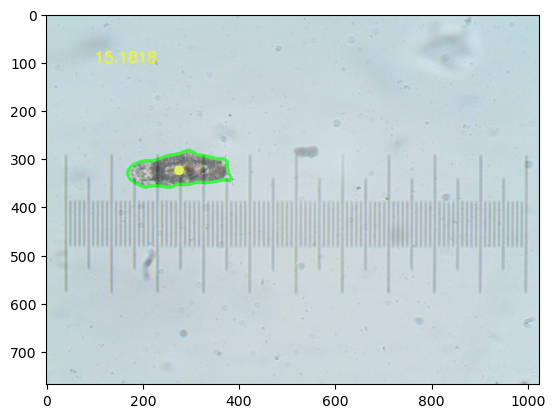

In [18]:
plt.imshow(im)
plt.show()

[4.  2.6]


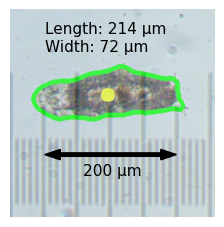

In [19]:
def tardigradeSize(ax,im):

    import matplotlib.patches as mpatches
    from matplotlib import colormaps as cm

    im_cropped = im[150:600,:] # if labeled time and whole micrometer
    # im_cropped = im[150:425,150:400]  # if just length and width

    arrow_x = 280
    arrow_y = 260
    arrow_width = 5
    dx = 95
    dy = 0

    # text for size and for scalebar
    ax.text(arrow_x - dx,110,'Length: 214 µm\nWidth: 72 µm', color='k', fontsize=axis_fontsize)
    ax.text(arrow_x-40, arrow_y+30, '200 µm', color='k', fontsize=axis_fontsize)

    # arrow for scalebar
    arrow_right = mpatches.FancyArrow(arrow_x, arrow_y, dx, dy,
                                width=arrow_width, length_includes_head=True, color='k')
    ax.add_patch(arrow_right)
    arrow_left = mpatches.FancyArrow(arrow_x, arrow_y, -dx, dy,
                                width=arrow_width, length_includes_head=True, color='k')
    ax.add_patch(arrow_left)

    # scatter 'line' and text for timeline
    # time_x = 750
    # time_dx = 150
    # time_y = 40
    # num_points = 100
    # cmap_name = 'plasma'
    # cmap = cm.get_cmap(cmap_name)
    # cols = cmap(np.linspace(0,1,num_points))
    # ax.scatter(np.linspace(time_x,time_x+time_dx,num_points),[time_y]*num_points, c=cols, s=5)
    # ax.text(time_x-90, time_y+12, 'O s', fontsize=fontsize)
    # ax.text(time_x+time_dx+5, time_y+10, '15 s', fontsize=fontsize)

    ax.axis('off')
    ax.set_xlim([135,430]) # if include whole micrometer and tracked path
    ax.set_ylim([350,50])
    ax.imshow(im_cropped)
    return ax

f=plt.figure(figsize=(4,2.6))
ax=f.add_axes([0.1,0.1,0.8,0.8])

ax = tardigradeSize(ax,im)
print(f.get_size_inches())
plt.show()

In [20]:
def scat(ax,x,y,xlab,ylab):
    r,p = stats.spearmanr(x,y)
    if p < 0.05:
        sns.regplot(ax=ax, x=x, y=y, scatter_kws={'s':marker_size,'color':marker_color}, 
                    line_kws={'color':marker_color,'linewidth':2})
    else:
        ax.scatter(x,y,s=marker_size,alpha=marker_alpha,color=marker_color)
    print(xlab + ' vs. ' + ylab + ' ρ = ' + str(np.round(r,3)) +  ', p = ', str(np.round(p,3)))
    ax.set_xlabel(xlab)
    ax.set_ylabel(ylab)
    print('n = ' + str(len(x)))
    return ax

Body Length (µm) vs. Body Width (µm) ρ = 0.905, p =  0.0
n = 103


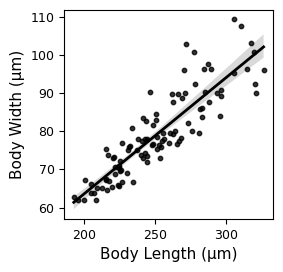

In [21]:
lengths = path_summaries_df['Body Length (mm)'].values*1000
widths = path_summaries_df['Body Width (mm)'].values*1000
xlab = 'Body Length (µm)'
ylab ='Body Width (µm)'

f = plt.figure(figsize=(2.61,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = scat(ax,lengths,widths,xlab,ylab)
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

... getting first frame ...
... getting last frame ...
Last successful frame = 503


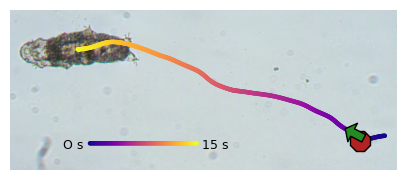

In [22]:
'''Track with Stop & Turn points'''

def trackingExample(ax,im,addSt3opsTurns=True):
    cmap_name = 'plasma'
    cmap = mpl.colormaps.get_cmap(cmap_name)

    # add color bar for timeline on separate axis
    # ax_colorbar = f.add_axes([0.9,0.2,0.02,0.6])   
    # norm = mpl.colors.Normalize(vmin=0, vmax=tracked_df.times.values[-1])
    # plt.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap), label = 'Time (sec)', cax = ax_colorbar)

    # add fake color bar for timeline
    time_x = 300
    time_dx = 200
    time_y = 500
    num_points = 100
    cols = cmap(np.linspace(0,1,num_points))
    ax.scatter(np.linspace(time_x,time_x+time_dx,num_points),[time_y]*num_points, c=cols, s=5)
    ax.text(time_x-50, time_y+10, 'O s', fontsize=tick_fontsize)
    ax.text(time_x+time_dx+10, time_y+10, '15 s', fontsize=tick_fontsize)

    # plot image of tardigrade
    # combined_frame = gaitFunctions.superImposedFirstLast(movie_file)
    # combined_frame = combined_frame
    first_frame, last_frame = gaitFunctions.getFirstLastFrames(movie_file)
    frame_to_show = last_frame
    frame_to_show = frame_to_show[:, :, [2, 1, 0]]
    ax.imshow(frame_to_show) # combined_frame or last_frame

    # plot tardigrade path
    xcoords = tracked_df.xcoords.values
    ycoords = tracked_df.ycoords.values
    smoothedx = tracked_df.smoothed_x.values
    smoothedy = tracked_df.smoothed_y.values
    cols = cmap(np.linspace(0,1,len(smoothedx)))
    # ax.scatter(xcoords, ycoords, c = 'grey', s=20) # raw data 'dimgrey' or 'black' or 'slategray'
    ax.scatter(smoothedx, smoothedy, c = cols, s=5) # smoothed data

    # add stops and turns
    if addStopsTurns:

        arrowup, arrowdown, cut_arrowup, cut_arrowdown = gaitFunctions.getArrowMarkers()
        markersize = 15
        stop_color = 'firebrick' # 'tab:red' or 'firebrick'
        turn_color = 'forestgreen' # 'limegreen' or 'tab:green' or 'green' or 'forestgreen'

        # get runs of stops ... the stop marker will be plotted in the beginning of the stop bout
        stops = tracked_df.stops.values
        stop_bouts = gaitFunctions.one_runs(stops)
        # stop_indices = [int((x[0]+x[1])/2) for x in stop_bouts] #  at middle of bout
        stop_indices = [x[0] for x in stop_bouts] # at beginning of bout
        stop_x = [smoothedx[i] for i in stop_indices]
        stop_y = [smoothedy[i] for i in stop_indices]

        # plot stops
        ax.plot(stop_x, stop_y, "8", markersize=markersize, markerfacecolor=stop_color, markeredgecolor="k")

        # get turns ... the turn marker will be plotted at the END of the turn
        turns = tracked_df.turns.values
        turn_bouts = gaitFunctions.one_runs(turns)
        turn_indices = [x[1] for x in turn_bouts]

        turn_x = [smoothedx[i] for i in turn_indices]
        turn_y = [smoothedy[i] for i in turn_indices]

        turn_directions = np.zeros(len(turn_bouts))
        for i, idx in enumerate(turn_indices):
            try:
                turn_directions[i] = np.mean(tracked_df.filtered_bearings.values[idx:idx+5])
            except:
                turn_directions[i] = tracked_df.filtered_bearings.values[idx]

        # plot turns
        for i, angle in enumerate(turn_directions):
            t = mpl.markers.MarkerStyle(marker=arrowup)
            t._transform = t.get_transform().rotate_deg(-angle)
            ax.plot(turn_x[i], turn_y[i], marker=t, markersize=markersize, markerfacecolor=turn_color, markeredgecolor="k")

    ax.set_ylim([550,250])
    ax.set_xlim([150,875])
    ax.axis('off')

    return ax
        
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/analyses_summaries/02 tracking_path')
excel_filename = 'iw_30Jan_tardigrade01_exemplaris_037-058.xlsx'
movie_file = 'iw_30Jan_tardigrade01_exemplaris_037-058.mov'
tracked_df = pd.read_excel(excel_filename, sheet_name='pathtracking', index_col=None)

f = plt.figure(figsize=(5,2))
ax = f.add_axes([0.1, 0.1, 0.8, 0.8])
addStopsTurns = True
ax = trackingExample(ax,im,addStopsTurns)
plt.show()

Percentage Cruising = 91.0


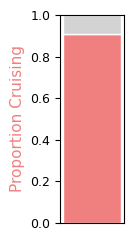

In [23]:
# add 'cruising' percentage plot
def cruise(ax):
    plotClip.cruisingProportionPlot(ax, tracked_df)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    return ax

f=plt.figure(figsize=(0.8,2.6))
cruisingax = f.add_axes([0.1, 0.1, 0.8, 0.8])
cruisingax=cruise(cruisingax)
plt.show()

Body Length (µm) vs. Cruising Speed
(µm/sec) ρ = 0.371, p =  0.0
n = 103


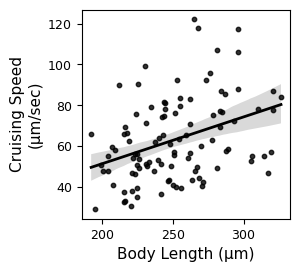

In [24]:
'''length vs. speed'''

lengths = path_summaries_df['Body Length (mm)'].values*1000
cruising_speed_mm = path_summaries_df['Speed (mm/sec cruising)'].values*1000
xlab = 'Body Length (µm)'
ylab ='Cruising Speed\n(µm/sec)'

f = plt.figure(figsize=(2.61,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = scat(ax,lengths,cruising_speed_mm,xlab,ylab)
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

Body Size (mm$^2$) vs. Cruising Speed
(µm/sec) ρ = 0.343, p =  0.0
n = 103


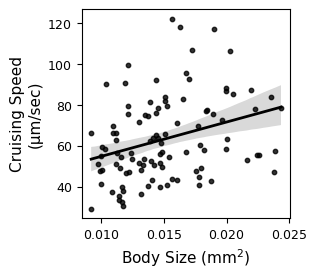

In [25]:
'''Area vs Speed'''

areas = path_summaries_df['Body Size (mm^2)'].values
cruising_speed_mm = path_summaries_df['Speed (mm/sec cruising)'].values*1000
xlab = 'Body Size (mm$^2$)'
ylab = 'Cruising Speed\n(µm/sec)'

f = plt.figure(figsize=(2.61,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = scat(ax,areas,cruising_speed_mm,xlab,ylab)
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

Body Size (mm$^2$) vs. Cruising Speed
(bodylength/sec) ρ = -0.029, p =  0.769
n = 103


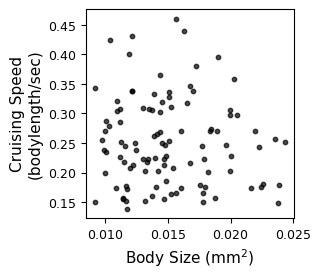

In [26]:
'''Area vs Normalized Speed'''

areas = path_summaries_df['Body Size (mm^2)'].values
cruising_speed_bodylength = path_summaries_df['Speed (body lengths / sec cruising)'].values
xlab = 'Body Size (mm$^2$)'
ylab = 'Cruising Speed\n(bodylength/sec)'

f = plt.figure(figsize=(2.61,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = scat(ax,areas,cruising_speed_bodylength,xlab,ylab)
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

Body Length (µm) vs. Cruising Speed
(bodylength/sec) ρ = -0.003, p =  0.98
n = 103


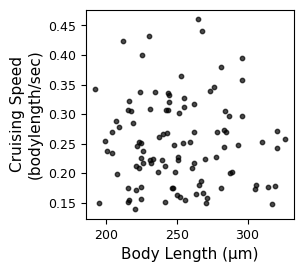

In [27]:
'''Length vs. Normalized speed'''

lengths = path_summaries_df['Body Length (mm)'].values*1000
cruising_speed_bodylength = path_summaries_df['Speed (body lengths / sec cruising)'].values
xlab = 'Body Length (µm)'
ylab = 'Cruising Speed\n(bodylength/sec)'

f = plt.figure(figsize=(2.61,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = scat(ax,lengths,cruising_speed_bodylength,xlab,ylab)
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

Width:Length Ratio vs. Cruising Speed
(bodylength/sec) ρ = -0.368, p =  0.0
n = 103


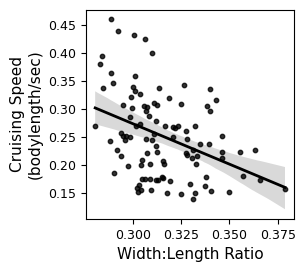

In [28]:
'''width:length ratio vs. Normalized speed '''

ratios = path_summaries_df['Body Width/Length Ratio'].values
cruising_speed_bodylength = path_summaries_df['Speed (body lengths / sec cruising)'].values
xlab = 'Width:Length Ratio'
ylab = 'Cruising Speed\n(bodylength/sec)'

f = plt.figure(figsize=(2.61,2.61))
ax = f.add_axes([0.1,0.1,0.8,0.8])
ax = scat(ax,ratios,cruising_speed_bodylength,xlab,ylab)
ax.xaxis.label.set_size(axis_fontsize)
ax.yaxis.label.set_size(axis_fontsize)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)
plt.show()

# Put Whole Figure Together

Body Length (µm) vs. Body Width (µm) ρ = 0.905, p =  0.0
n = 103
... getting first frame ...
... getting last frame ...
Last successful frame = 503
Percentage Cruising = 91.0
Body Length (µm) vs. Cruising Speed
(bodylength/sec) ρ = -0.003, p =  0.98
n = 103
Width:Length Ratio vs. Cruising Speed
(bodylength/sec) ρ = -0.368, p =  0.0
n = 103


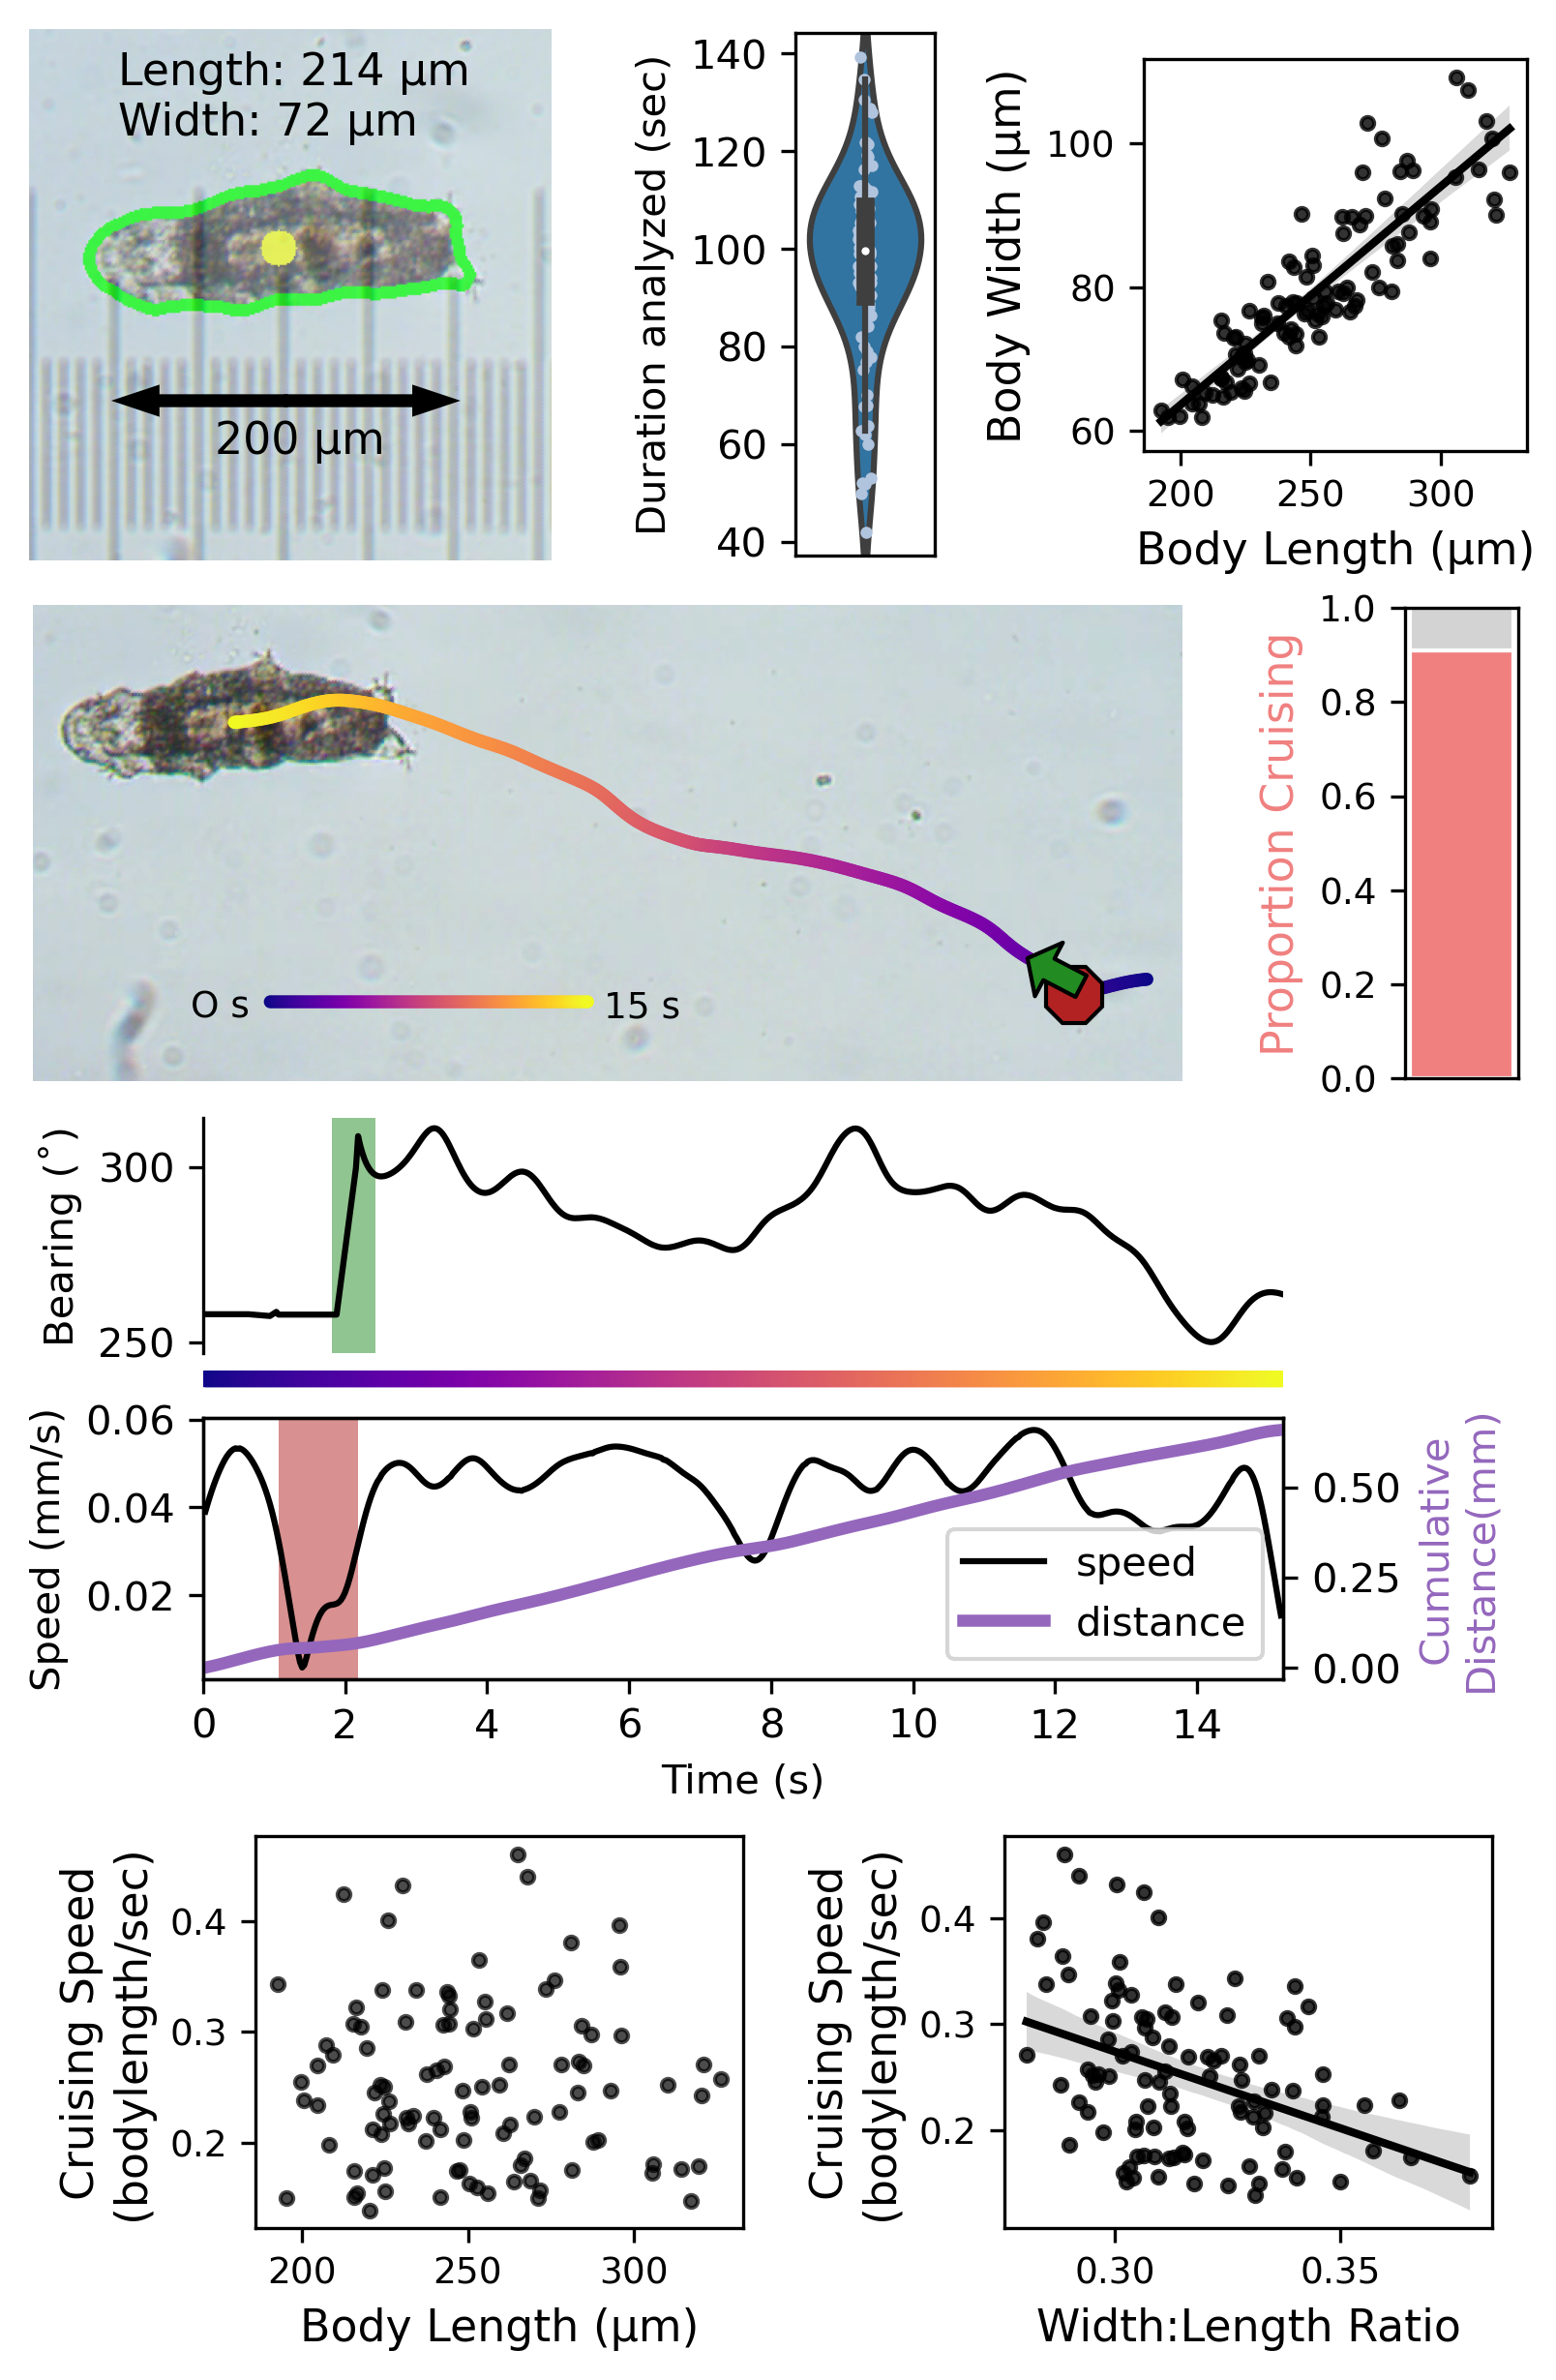

In [31]:
'''
tardigradeSize(ax,im) ... lengthVWidth(ax,path_summaries_df)
trackingExample(ax,im,addStopsTurns=True) ... cruise(ax)
nSpeedVLength(ax) ... nSpeedVRatio(ax)
'''
f = plt.figure(figsize=(6,9),dpi=300)
tracked_df = pd.read_excel(excel_filename, sheet_name='pathtracking', index_col=None)
path_stats = gaitFunctions.loadPathStats(movie_file)
scale = float(path_stats['scale'])
unit = path_stats['unit']
last_frame = tracked_df.times.values[-1]

# set up axes positions
size_ax = f.add_axes(     [0.06, 0.73,0.3,  0.22])
durations_ax = f.add_axes([0.5, 0.74,0.08, 0.20])
lw_ax = f.add_axes(       [0.7, 0.78,0.22, 0.15])

track_ax = f.add_axes(    [0.062,0.51,0.66,0.24])
cruise_ax = f.add_axes(   [0.85, 0.54,0.065,0.18])

bearing_ax = f.add_axes(   [0.16, 0.435, 0.62, 0.09])
timeribbon_ax = f.add_axes([0.16, 0.38, 0.62, 0.09])
speed_ax = f.add_axes(     [0.16, 0.31, 0.62, 0.10])


nsvl_ax = f.add_axes(     [0.19,0.1,0.28,0.15]) # scatter of length vs normalized speed
nsvr_ax = f.add_axes(     [0.62,0.1,0.28,0.15]) # scatter of width:length vs normalized speed

# show tardigrade with scale bar and size annotations
size_ax=tardigradeSize(size_ax,im)

# box plot of durations analyzed
durations_ax = gaitFunctions.singleViolinPoints(durations_ax, 
                                           path_summaries_df, 
                                           'Duration analyzed (sec)', True)

# scatter plot of length vs. width
lw_ax=scat(lw_ax,lengths,widths,'Body Length (µm)','Body Width (µm)')

# tracking example
track_ax=trackingExample(track_ax,im,True)

# percentage cruising
cruise_ax = cruise(cruise_ax)

# bearing change plot
bearing_ax = plotClip.bearingChangePlot(bearing_ax, tracked_df)
xlim = [0,last_frame]
bearing_ax.set_xlim(xlim)

# time ribbon plot
timeribbon_ax = plotClip.timeRibbonPlot(timeribbon_ax, tracked_df)
timeribbon_ax.axis('off')
timeribbon_ax.set_xlim(xlim)

# speed and cumulative distance plot
speed_ax, distax = plotClip.speedDistancePlot(speed_ax, tracked_df, scale, unit)
distax.yaxis.label.set_text('Cumulative\nDistance(mm)')
speed_ax.set_xlim(xlim)

# scatter plots
nsvl_ax = scat(nsvl_ax,lengths,cruising_speed_bodylength,'Body Length (µm)','Cruising Speed\n(bodylength/sec)')
nsvr_ax = scat(nsvr_ax,ratios,cruising_speed_bodylength,'Width:Length Ratio','Cruising Speed\n(bodylength/sec)')

# adjust axis parameters
for ax in [lw_ax, nsvl_ax, nsvr_ax]:
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

plt.show()

Body Length (µm) vs. Cruising Speed
(µm/sec) ρ = 0.371, p =  0.0
n = 103
Body Size (mm$^2$) vs. Cruising Speed
(µm/sec) ρ = 0.343, p =  0.0
n = 103
Body Size (mm$^2$) vs. Cruising Speed
(bodylength/sec) ρ = -0.029, p =  0.769
n = 103


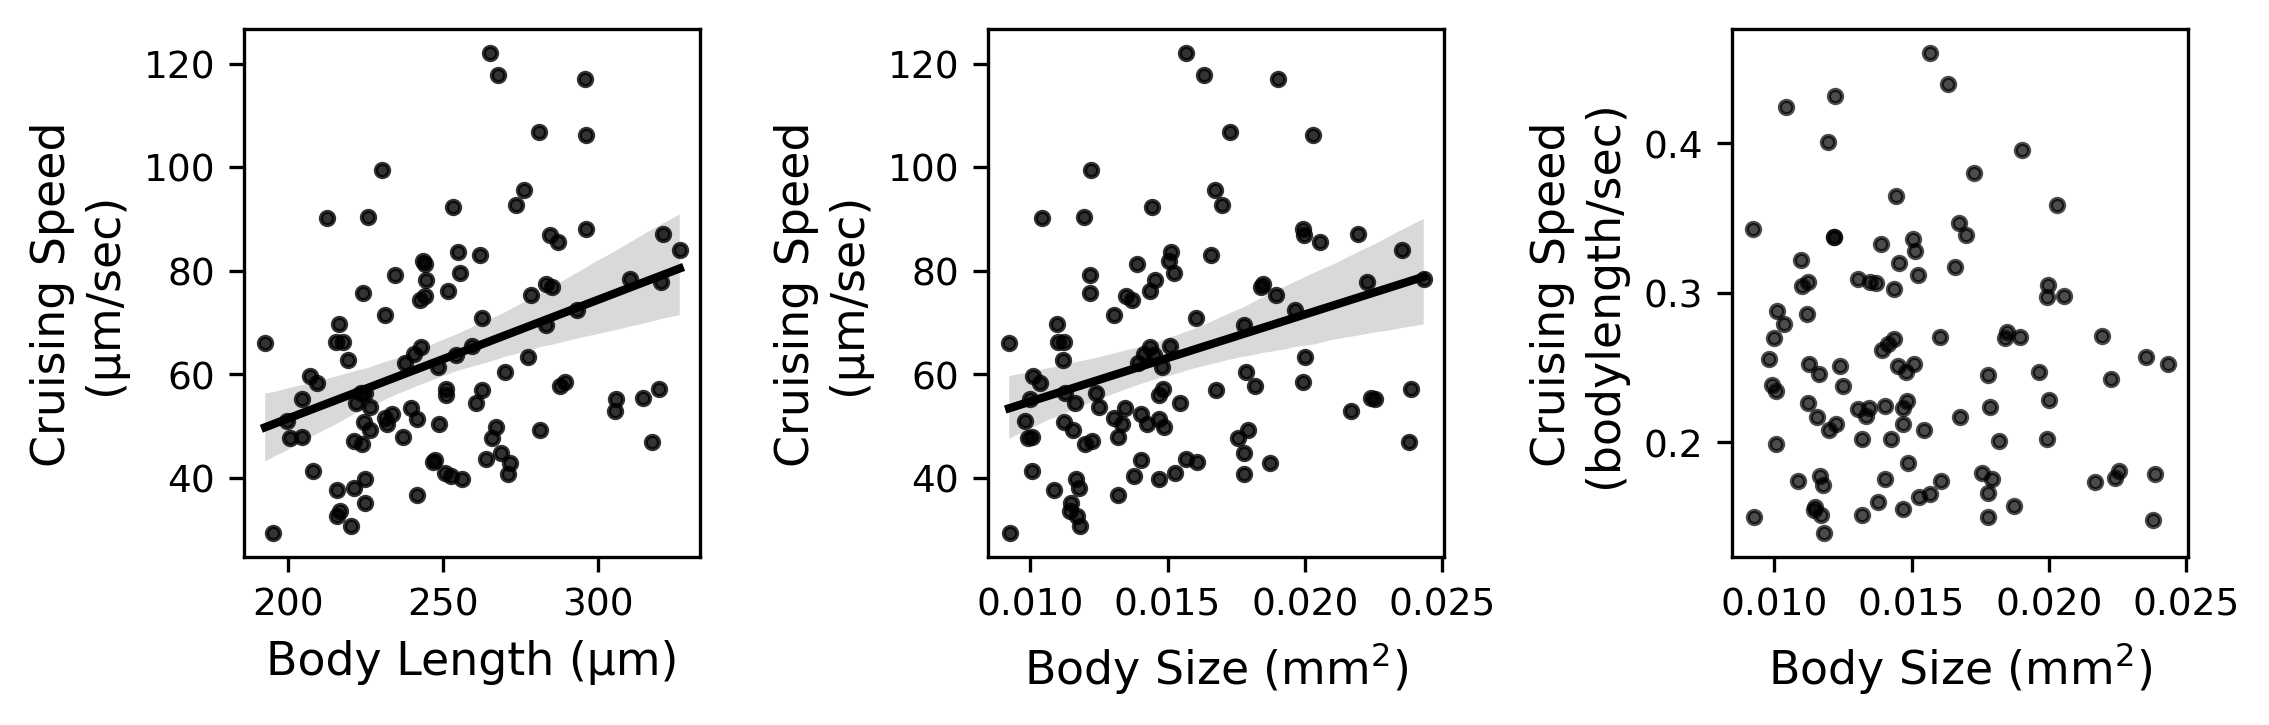

In [32]:
'''
supplemental fig
speedVLength(ax) ... speedVArea(ax) ... nSpeedVArea(ax)
'''
f=plt.figure(figsize=(8,2.2),dpi=300)
svl_ax = f.add_axes([0.1,0.1,0.19,0.8])
svl_ax = scat(svl_ax,lengths,cruising_speed_mm,'Body Length (µm)','Cruising Speed\n(µm/sec)')
sva_ax = f.add_axes([0.41,0.1,0.19,0.8])
sva_ax = scat(sva_ax,areas,cruising_speed_mm,'Body Size (mm$^2$)','Cruising Speed\n(µm/sec)')
nsva_ax = f.add_axes([0.72,0.1,0.19,0.8])
nsva_ax = scat(nsva_ax,areas,cruising_speed_bodylength,'Body Size (mm$^2$)','Cruising Speed\n(bodylength/sec)')

for ax in [svl_ax, sva_ax, nsva_ax]:
    ax.xaxis.label.set_size(axis_fontsize)
    ax.yaxis.label.set_size(axis_fontsize)
    ax.tick_params(axis='both', which='major', labelsize=tick_fontsize)

# More About Tardigrade Size
### Nirody figure 1A, 1B

In [ ]:
'''
Nirody figure 1A, 1B ... tardigrade size
they report body length 350.40 ± 46.04 (standard deviation)
n = 43 tardigrades

the tardigrade they show in 1B looks like a young one, with no eggs . . . 
but ours are smaller? See confirmation of size measurements a few cells down.

Also see 'tardigrade size check' folder in analyses_summaries
''' 

# load the path summaries data into a dataframe
os.chdir('/Users/iwoods/OneDrive - Ithaca College/2024_movement_disorder_paper/analyses_summaries')
path_df = pd.read_excel(excel_file, sheet_name='path_summaries', index_col=None)
num_tardigrades = len(path_df.individual.values)
body_lengths = path_df['Body Length (mm)'].values * 1000
body_length = np.round(np.mean(body_lengths),2)
body_length_sd = np.round(np.std(body_lengths),2)

print('n = ' + str(num_tardigrades) + ' tardigrades')
print('body length = ' + str(body_length) + ' ± ' + str(body_length_sd) + ' µm')


In [ ]:
# more about size ... 
f,(a1,a2) = plt.subplots(1,2,figsize=(12,5))
a1.hist(body_lengths)
a1.set_ylabel('number of individuals',fontsize=18)
a1.set_xlabel('Body Length (µm)', fontsize=18)
a1.tick_params(axis='x', labelsize=18)
a1.tick_params(axis='y', labelsize=18)
body_widths = path_df['Body Width (mm)'].values * 1000
a2.scatter(body_lengths,body_widths,s=50,c='k')
a2.set_ylabel('Body Width (µm)',fontsize=18)
a2.set_xlabel('Body Length (µm)',fontsize=18)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.tight_layout()
plt.show()

# Looking at size differences
Sizes are different between Nirody paper and our analyses ... <br>

Summary of analysis below - if our pix-per-mm 'scales' are correct (and they seem to be), our sizes are correct.

Re-check our size measurements: <br>

On images from the Amscope inverted scope with MD310B camera, capturing images at 1024x768.<br>
Measuring micrometer via Python = <br>
* about 957 pixels (956 on 8 Dec, 948 on 12 Dec, 957 on 14 Dec, 958 on 30 Jan, 955 on 1 Feb)<br>
* Confirmed these values on Preview app, Confirmed on FIJI<br><br>

Selected three tardigrades from 9Nov23 (AmScope) <br>
to measure pixels in FIJI and compare to PYTHON-calculated values:<br>
* iw_9Nov_tardigrade01_exemplaris_033-060_first  145 pix = 151.67 µm (FIJI) vs. 155.98 µm (path_stats)
* iw_9Nov_tardigrade02_exemplaris_080-087_first  230 pix = 240.58 µm (FIJI) vs. 253.72 µm (path_stats)
* iw_9Nov_tardigrade04_exemplaris_097-117_first  261 pix = 273.01 µm (FIJI) vs. 280.70 µm (path_stats)
<br>

On images from the Te-Wen inverted scope with Te-Wen camera, capturing images at 1920x1080.<br>
Measuring micrometer via Python = <br>
* about 1633 pixels (1637 in adults_15Sep, 1631 in babies_15Sep, 1633 in adults_28Nov)
* Confirmed these values on Preview app, Confirmed on FIJI<br><br>

Selected three tardigrades from 28Nov23 (Te-Wen Scope and camera) <br> 
to measure pixels in FIJI and compare to PYTHON-calculated values:<br>
* ea_16jul_tardigrade37A-day4_050-068_first  229.12 pix = 140.30 µm (FIJI) vs. 144.04 µm (path_stats)
* ea_28nov_exemplaris_tardigrade15_027-035_first  497.29 pix = 304.52 µm (FIJI) vs. 289.14 µm (path_stats)
* gi_15sep_tardigrade8_041-070_first  341.71 pix = 209.25 µm (FIJI) vs. 201.17 µm (path_stats)